# Практическое ДЗ-2. Использование ALS для построения рекомендательной модели

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений. 

In [1]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import tensorly
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) или [disk.yandex.ru](https://disk.yandex.ru/d/HIjLehGZEcCRig) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [7]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A \in \mathbb R^{m \times n}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{i,j}=1$) и отрицательные (`Rating < 4` &mdash; $A_{i,j} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате хранения разреженных матриц [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)), который поддерживает матричное умножение на numpy массивы: ```A @ X ```.

In [8]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [9]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

Далее в задаче мы будем строить рекомендации пользователям на основе малорангового приближения матрицы $A$ (матрицы $A_{train}$ в рамках обозначений выше). 
Обратим внимание, что из-за ограничений по памяти мы не можем сформировать матрицу $A$ в виде numpy массива, а значит теряем доступ к ```np.linalg.svd```. Поэтому мы будем реализовывать метод ALS, в котором требуется только умножение на матрицы $A$ и $A^\top$, что поддерживается разреженными форматами хранения матриц (CSR, COO и тд).

### a. (35 баллов) Вычисление вспомогательных функционалов

  1. **(15 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $f(U, V^\top) = \|A - UV^\top\|_F$ по всем $U \in \mathbb R^{m \times r}$ и $V  \in \mathbb R^{n \times r}$. Первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - UV^\top\|_F$ для заданных $A$, $U$, $V^\top$. Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - UV^\top\|_F^2$ через скалярное произведение $\langle X,Y \rangle_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Имеется в виду, что ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив).
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @; либо умножения сложности $O(mr^2), O(nr^2)$. Также отметим, что норма матрицы $A$ уже дана, заново её вычислять не надо. Везде считайте $r < m, n$.

**Вычисления и сложность:**

$$ Tr((A-UV^T)^T(A-UV^T)) = Tr((A^T-VU^T)(A-UV^T)) = Tr(A^TA + A^TUV^T - VU^TA + (VU^T)(UV^T)) = $$
$$ = \lVert A \rVert_{F}^2 - 2Tr(A^TUV^T) + Tr(V^TVU^TU) = \lVert A \rVert_{F}^2 - 2Tr((V^TA^T)U) + Tr((V^TV)(U^TU))$$

Вычисление $V^TA^T$ разрешено, получается матрица размера $r\times m$, вычисление прозведения матриц размеров $r\times m$ $(V^TA^T)$ и $m\times r$ $(U)$ имеет сложность $O(mr^2)$. 

$V^TV$ : $r\times n \times n \times r$, $O(nr^2)$. 

$U^TU$ : $r\times m \times m \times r$, $O(mr^2)$. 

$V^TVU^TU$ : $r\times r \times r\times r$, $O(r^3)$. 
Итоговая сложность: $O(max(m, n)r^2)$.

In [10]:
def als_functional(A, A_norm, U, VT):
    a_norm_sq = A_norm ** 2
    TrVtAtU = np.trace((VT @ A.T) @ U)
    TrVtVUtU = np.trace((VT @ VT.T) @ (U.T @ U))
    res = a_norm_sq - 2 * TrVtAtU + TrVtVUtU
    return np.sqrt(res)


**Замечание:** Если вы не сможете выполнить следующие два пункта, можете их пропустить. Они не являются обязательными для следующих заданий.

  2. **(10 баллов)** Ещё одной метрикой сходимости ALS-процесса, помимо стабилизации самого функционала, может служить так называемое расстояние между подпространствами. Расстоянием между подпространствами $L_1 \subset \mathbb{R}^m$ и $L_2 \subset \mathbb{R}^m$ будем называть число $\|P(L_1) - P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Опишите алгоритм вычисления расстояния между двумя подпространствами $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^T U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь фактом, что ортопроекторы являются матрицами малого ранга $r$, и техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

**YOUR WORDS GO HERE**
$U_1, U_2$ - полноранговые, $\Longrightarrow$ ортопроекторы на $Im(U_1)$ и  $Im(U_2)$- это $U_1U_1^T$ и $U_2U_2^T$

$\lVert U_1U_1^T - U_2U_2^T \rVert_{2} = \{$лекция 3, слайд 21$\} = \lVert [U_1U_2][U_1 -U_2]^T\rVert_{2} = \lVert Q_1R_1(Q_2R_2)^T \rVert_{2} = \lVert Q_1R_1R_2^TQ_2 \rVert_{2} = \lVert Q_1U\Sigma V^TQ_2 \rVert_{2}$ - получили SVD разложение.

QR разложение для матрицы $[U_1U_2]$ размера $m \times 2r$ работает за $O(mr^2)$, аналогично для $[U_1-U_2]$.
SVD разложение для марицы $[R_1R_2^T]$ размера максимум $2r \times 2r$ разботает за $O(r^2)$.
Далее для вычисления нормы нужно взять элемент $\Sigma_{11}$.
Итоговая сложность $O(mr^2)$.


  3. **(10 баллов)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [11]:
def dist_between_subspaces(U1, U2):
    U_ = np.concatenate((U1, U2), axis=1)
    _, R1 = np.linalg.qr(U_)
    V_ = np.concatenate((U1, -U2), axis=1)
    _, R2 = np.linalg.qr(V_)
    
    _, Sigma, _ = np.linalg.svd(R1@R2.T)
    return Sigma[0]

### b. (30 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции).

Вам будет необходимо вернуть две матрицы: $U$ и $V^\top$, образующие скелетное разложение результирующего приближения; где $U$ имеет ортонормированные столбцы. Также нужно вернуть 3 списка:


*   Список значений функционала $f(U_k, V^\top_k) = \|A - U_k V^\top_k\|_F$

*   Список изменений значений функционала $\delta_k = f(U_{k-1}, V^\top_{k-1}) - f(U_k, V^\top_k)$

*   Список растояний между пространствами $\|P(U_{k-1}) - P(U_{k})\|_2$

В качестве критерия остановки будем использовать величину $\delta_k$. При значении $\delta_k \le tolerance$ алгоритм должен остановиться. При указании `debug=True` печатайте номер текущей итерации и последнюю $\delta_k$, а также любую дополнительную интересную вам информацию. 

Используйте реализованные выше функции. Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.

**Замечание:** Если вы не реализовали dist_between_subspaces, то вместо третьего списка возращайте None.

In [12]:
from scipy.stats import ortho_group

In [13]:
def gen_fixed_rank(r, x):
    a = ortho_group.rvs(dim=r)
    b = np.random.rand(r, x-r).T
    M = np.concatenate((a, b), axis=0)
    Q, _ = np.linalg.qr(M)
#     print(Q.shape,np.linalg.matrix_rank(Q))
    return Q

In [14]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rank, tolerance=1e-2, debug=False):
    fs, deltas, dists = [], [], []
    
    m, n = A.shape
    U = gen_fixed_rank(rank, m)
    V = gen_fixed_rank(rank, n)

    A_norm = scipy.sparse.linalg.norm(A)
    f = als_functional(A, A_norm, U, V.T)
    fs.append(f)
    f_prev = f + 1 + tolerance
    i = 0
    while f_prev - f > tolerance:
        U0 = A @ V
        Q1, _ = np.linalg.qr(U0)
        dists.append(dist_between_subspaces(U, Q1))
        U = Q1

        V = A.T @ Q1
        f_prev = f
        f = als_functional(A, A_norm, U, V.T)
        

        deltas.append(f_prev - f)
        if debug:
            print('текущая итерация', i, 'delta', deltas[-1])
        i += 1
        
        fs.append(f)
        
    return U, V.T, fs, deltas, dists


Запустим метод на матрице `A_train` и посмотрим на убывание расстояния между соседними подпространствами от номера итерации.

текущая итерация 0 delta 220.20298649255665
текущая итерация 1 delta 121.21134349051795
текущая итерация 2 delta 14.646723228484234
текущая итерация 3 delta 4.087348226385302
текущая итерация 4 delta 1.5915343741733068
текущая итерация 5 delta 0.75913414917909
текущая итерация 6 delta 0.43166570400239834
текущая итерация 7 delta 0.2801618370547203
текущая итерация 8 delta 0.19723751278547752
текущая итерация 9 delta 0.1452399690265338
текущая итерация 10 delta 0.10971397853813869
текущая итерация 11 delta 0.08422181176706545


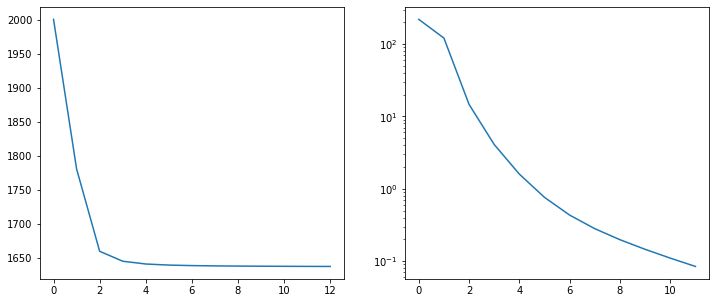

In [15]:
rank = 30
U_als, VT_als, fs, deltas, dists = ALS(A_train, rank, 0.1, debug=True)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].plot(fs)
axs[1].plot(deltas)
axs[1].semilogy();

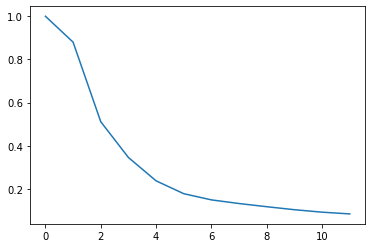

In [16]:
# если выполнили a.3

plt.plot(dists);

### c. (10 баллов) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также SVD из scipy, поддерживающее разреженные матрицы (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [17]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)
u1, s1, vh1 = randomized_svd(A_train, n_components=30)

u2, s2, vh2 = svds(A_train, k=30)

f1 = als_functional(A_train, A_norm, U_als, VT_als)
f2 = als_functional(A_train, A_norm, u1, np.diag(s1) @ vh1)
f3 = als_functional(A_train, A_norm, u2, np.diag(s2) @ vh2)

print('Als', f1)
print('Sklearn', f2)
print('Scipy', f3)

Als 1637.140909323074
Sklearn 1636.9250246003535
Scipy 1636.8271628864386


**Как видно, все способы показывают похожие результаты**

## d. (25 баллов) Построение рекомендаций
  1. **(10 баллов)** Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V^\top$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `n_recs` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`n_recs` рекомендаций, то есть `n_recs` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

  Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `known_ratings` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же.  **Подсказка:** используйте функцию `np.argsort`.

In [18]:
def recommend(VT, known_ratings, n_recs):
    Q, R = np.linalg.qr(VT.T)
    rec = Q @ (Q.T @ known_ratings.T)
    recs = np.flip((np.argsort(np.abs(rec), axis = 0)[-n_recs:, :].T), axis = 1)
    return recs

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [19]:
from scipy.sparse import find

def evaluate_model(VT, A_test, n_recs, batch_size=500):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users
            n_recs: requested number of recommendations
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-n_recs recommendations (or n_recs if it is missing)
    """
    
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(VT, A_test[nonempty_users[i:i + batch_size], :], n_recs + 1)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

  2. **(15 баллов)** Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V^\top$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `n_recs`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `n_recs == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [20]:
def get_hit_rates(VT, A_test, n_recs):
    hit_idx = evaluate_model(VT, A_test, max(n_recs))
    hit_rates = []
    for n in n_recs:
        hit_rates.append((np.array(hit_idx) < n).mean() * 100)
    return  hit_rates

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [21]:
U, VT = ALS(A_test[:1000], 30)[:2]


In [22]:
for _ in range(10):
    print(get_hit_rates(VT, A_test[:1000], [10]))


[13.182286302780637]
[11.637487126673532]
[13.491246138002062]
[12.667353244078269]
[14.315139031925849]
[13.594232749742533]
[11.328527291452112]
[9.680741503604532]
[10.401647785787848]
[12.049433573635428]


Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

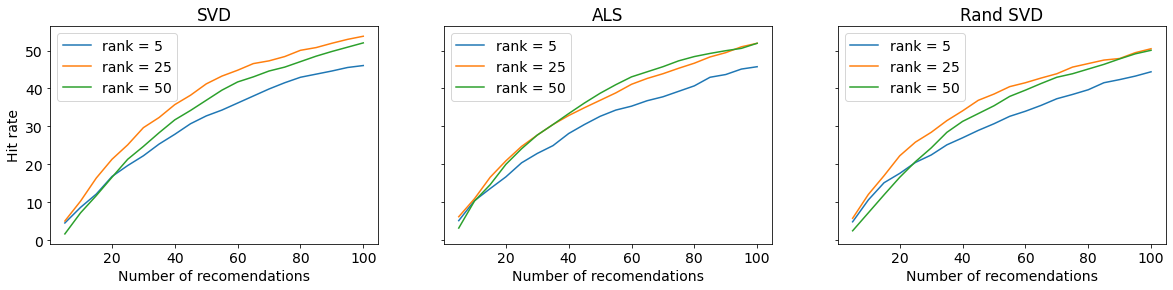

In [23]:
from scipy.sparse.linalg import svds

n_recs = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, VT_als, _, _, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(VT, A_test[:1000,:], n_recs)
        line, = ax.plot(n_recs, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

**Ранг 25 показывает наилучшие результаты, хотя иногда ранг 25 и 50 примерно одинаково работают в случае ALS (несколько раз запускала - получалось по-разному).**


## Бонус. Higher-order SVD (100 баллов)

**В бонусе разрешается использовать циклы только по размерности.**

1. (**20 баллов**) Напишите функцию ```tuck2full(G, Us)```, возвращающую полный тензор размера $n_1\times n_2 \times \ldots \times n_d$ по его разложению Таккера. Предусмотрите, чтобы функция работала и в случае, если в матрицах $U_1,U_2, \ldots, U_d$ строк меньше, чем столбцов. Вместо циклов используйте функцию ```np.einsum```.

$$G \rightarrow G_{(k)} - новое "ядро", r_k \rightarrow n_k$$ 
$$U_k*G_{(k)} \rightarrow G_k$$

In [2]:
def tuck2full(G, Us):

    R = G.shape
    d = len(R)
    new_shape = list(R)
    P = G.copy()
    

    for k in range(d):
        order = list(range(d))
        order[0], order[k] = order[k], order[0]
        Gk = np.transpose(P, order)
        Gk = np.reshape(Gk, (R[k], np.prod(new_shape) // R[k]), order='f')
        Gk = np.einsum('ij, jk -> ik', Us[k], Gk)
        new_shape[k] = Us[k].shape[0]
        to_reshape = new_shape.copy()
        to_reshape[0], to_reshape[k] = to_reshape[k], to_reshape[0]
        P = np.reshape(Gk, to_reshape, order='f')
        P = np.transpose(P, order)
    return P



2. (**35 баллов**) Реализуйте higher-order SVD алгоритм для нахождения разложения Таккера данного $d$-мерного массива $A\in\mathbb{R}^{n_1\times \ldots \times n_d}$. Алгоритм должен находить малоранговое приближение $A$ с относительной точностью не хуже $\varepsilon$ во Фробениусовой норме. Функция должна вернуть ядро и факторы Таккера у приближающего тензора. Для получения ядра Таккера будет удобно воспользоваться функцией ```tuck2full```.

In [3]:
from sklearn.utils.extmath import randomized_svd

In [4]:
def get_best(Ak, eps, maxr=10):
    A_norm = np.linalg.norm(Ak)
    U, _, _ = randomized_svd(Ak, maxr)
    
    tolerance = eps * A_norm
    for k in range(maxr, 0, -1):
        if np.linalg.norm(Ak - U[:, :k] @ U[:, :k].T @ Ak) >= tolerance:
            break
    return U[:, :k]

In [5]:
def hosvd(A, eps):
    n = A.shape
    Ust = []
    Us = []
    epsk = eps / np.sqrt(len(n))
    for k in range(len(A.shape)):
        order = list(range(len(A.shape)))
        order[0], order[k] = order[k], order[0]
        Ak = np.transpose(A, order)
        Ak = np.reshape(Ak, (n[k], np.prod(A.shape)//n[k]), order='f')
        
        maxr = np.linalg.matrix_rank(Ak) if eps != 0 else 10
        Uk = get_best(Ak, epsk)
        Ust.append(Uk.T)
        Us.append(Uk)
        
    t_core = tuck2full(A, Ust)
    Us = tuple(Us)
    return t_core, Us

3. (**5 баллов**) Примените функцию ```hosvd``` к тензору размера $25 \times 50 \times 75 \times 100$ с элементами
$$
    a_{ijkl} = \frac{1}{i + j + k + l + 1}, \quad i,j,k,l=0,1,...
$$
для малорангового приближения с точностью $10^{-6}$. Массив $A$ соберите с помощью функции ```np.meshgrid```. Напечатайте получившиеся ранги и относительную ошибку полученного малорангового приближения (для этого используйте функцию ```tuck2full```).

In [28]:
i, j, k, l = np.array(np.meshgrid([range(25)], [range(50)], [range(75)], [range(100)], indexing='ij'))

A = 1 / (i + j + k + l + 1)
eps = 1e-6

G, Us = hosvd(A, eps)
print("ранги приближения: ", G.shape)
Ahosvd = tuck2full(G, Us)
print("относительная ошибка приближения", np.linalg.norm(A - Ahosvd) / np.linalg.norm(A))


ранги приближения:  (7, 8, 8, 9)
относительная ошибка приближения 3.643815064529363e-06


4. (**15 баллов**) Докажите, что норма Фробениуса приближения HOSVD $A'$ совпадает с её ядром Таккера $G'$:

$$
  \|A'\|_F = \|G'\|_F
$$

**По утверждению с лекции $vec(A) = vec([G, U_1, \dots, U_d]) = (U_1 \otimes \dots \otimes U_d)vec(G)$, у $U_i$ ортонормированы столбцы, а Фробениусова норма матрицы - 2-норма вектора. Значит, надо показать, что $U_1 \otimes \dots \otimes U_d$ - имеет ортонормированные столбцы, т. к. 2-норма вектора унитарно-инвариантная и $\lVert G \rVert_{F}^2 = \lVert vec(G) \rVert_{2}$**

$$U \textrm{имеет ортонормированные столбцы} \Longleftrightarrow U^*U = I$$
$$(U_1 \otimes \dots \otimes U_d)^*(U_1 \otimes \dots \otimes U_d) =$$
$$ = (U_1^* \otimes \dots \otimes U_d^*)(U_1 \otimes \dots \otimes U_d) =$$
$$= (U_1^*U_1) \otimes (U_2^* \otimes \dots \otimes U_d^*)(U_2 \otimes \dots \otimes U_d) = $$
$$= I_1 \otimes (U_2^* \otimes \dots \otimes U_d^*)(U_2 \otimes \dots \otimes U_d) = $$
$$= I_1 \otimes (U_2^*U_2) \otimes (U_3^* \otimes \dots \otimes U_d^*)(U_3 \otimes \dots \otimes U_d) = $$
$$= \dots = I_1 \otimes \dots \otimes I_{d-1} \otimes (U_d^*U_d) = $$
$$=I_1 \otimes \dots \otimes I_d = I \in \mathbb{C} ^{r_1\dots r_d \times r_1\dots r_d}$$


5. (**25 баллов**) Для заданного таккеровского разложения напишите функцию вычисления его нормы. Примените ее к разложению тензора размера 10000 x 10000 x 10000 со случайными Таккеровскими факторами и ядром мультилинейного ранга (10, 10, 10).

**Из доказательства выше мы поняли, что вычислять норму тензора через норму таккеровского ядра из его svd-разложения - хорошая идея. Но для больших размерностей такой алгоритм не очень эффективен. Поступим следующим образом: к каждому фактору таккеровского разложения применим сингулярное разложение, затем "выкинем" ортогональную матрицу U и применим изначальный алгоритм к разложению $A_0 = [G, \Sigma_1V^*_1, \dots, \Sigma_sV^*_s] \in \mathbb{C}^{r_1\times\dots\times r_s}$. Почему $\lVert A \rVert_{F} = \lVert A_0 \rVert_{F}$ ?**

$$\lVert A \rVert_{F} = \lVert vec(A) \rVert_2 = \lVert vec([G, U_1, \dots, U_d])\rVert_2 = \lVert (U_1 \otimes \dots \otimes U_d)vec(G) \rVert_2 = \lVert ((U^o_1\Sigma_1 V^*_1) \otimes \dots \otimes (U^o_d\Sigma_dV^*_d)vec(G) \rVert_2 = \lVert \Big((U^o_1 \otimes \dots \otimes U^o_d)  ((\Sigma_1 V^*_1) \otimes \dots \otimes (\Sigma_dV^*_d)\Big) vec(G)\rVert_2 = \lVert (U^o_1 \otimes \dots \otimes U^o_d)  \Big((\Sigma_1 V^*_1) \otimes \dots \otimes (\Sigma_dV^*_d)) vec(G)\Big)\rVert_2 =  \text{из задания 4 левая матрица состоит из ортонормированных столбцов} \rightarrow \text{при умножении на нее норма не меняется} = \lVert (\Sigma_1 V^*_1) \otimes \dots \otimes (\Sigma_dV^*_d)) vec(G)\rVert_2 =  \lVert vec(A^o) \rVert_{F} = \lVert A^o \rVert_{F}$$

In [42]:
def tuck_norm(G, Us):
    U_new = []
    for U in Us:
        u, s, vt = randomized_svd(U, 10)
        u_new = np.diag(s) @ vt
        U_new.append(u_new)
    
    A = tuck2full(G, U_new)
    S, Us_svd = hosvd(A, 0)
    
#     Ain = tuck2full(G, Us)
#     print('tensorly', tensorly.norm(Ain, order=2, axis=None)) #себя проверить для маленьких размеров
    return np.linalg.norm(S)


In [43]:
g = tensorly.random.random_tucker(shape=(10, 10, 10), rank=[10, 10, 10], full = True)
u1 = np.random.randn(10000, 10)
u2 = np.random.randn(10000, 10)
u3 = np.random.randn(10000, 10)



In [44]:
print('mine', tuck_norm(g, (u1, u2, u3)))

mine 2226895162.729871
